In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
def convert_raw_data(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Open'] = dataframe['Open'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Price'] = dataframe['Price'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['High'] = dataframe['High'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Low'] = dataframe['Low'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe = dataframe.sort_values(by='Date', ascending=True).reset_index(drop=True)
    return dataframe

In [3]:
df = pd.read_csv('VNI.csv')
df=convert_raw_data(df)
df1=df.reset_index()['Open']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
ratio = 0.8
train_size = int(ratio * len(df1))
test_size = int((1-ratio) * len(df1))


train_data = df1[:train_size]
test_data = df1[train_size:]


In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
42/42 [==============================] - 4s 45ms/step - loss: 0.0243 - val_loss: 0.0203
Epoch 2/100
42/42 [==============================] - 1s 35ms/step - loss: 8.0099e-04 - val_loss: 9.8428e-04
Epoch 3/100
42/42 [==============================] - 1s 34ms/step - loss: 1.6632e-04 - val_loss: 4.8376e-04
Epoch 4/100
42/42 [==============================] - 1s 35ms/step - loss: 1.5146e-04 - val_loss: 4.2088e-04
Epoch 5/100
42/42 [==============================] - 1s 33ms/step - loss: 1.4566e-04 - val_loss: 4.1622e-04
Epoch 6/100
42/42 [==============================] - 1s 34ms/step - loss: 1.3942e-04 - val_loss: 3.7668e-04
Epoch 7/100
42/42 [==============================] - 1s 35ms/step - loss: 1.3408e-04 - val_loss: 3.4158e-04
Epoch 8/100
42/42 [==============================] - 1s 33ms/step - loss: 1.3462e-04 - val_loss: 4.1135e-04
Epoch 9/100
42/42 [==============================] - 1s 35ms/step - loss: 1.2717e-04 - val_loss: 3.0959e-04
Epoch 10/100
42/42 [================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

19/19 [==============================] - 0s 8ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
mae = mean_absolute_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 1217.804818157334
MSE: 1509113.931160191
RMSE: 1228.4599835404454
MAPE: 1658.0545372024262


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1] -1
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


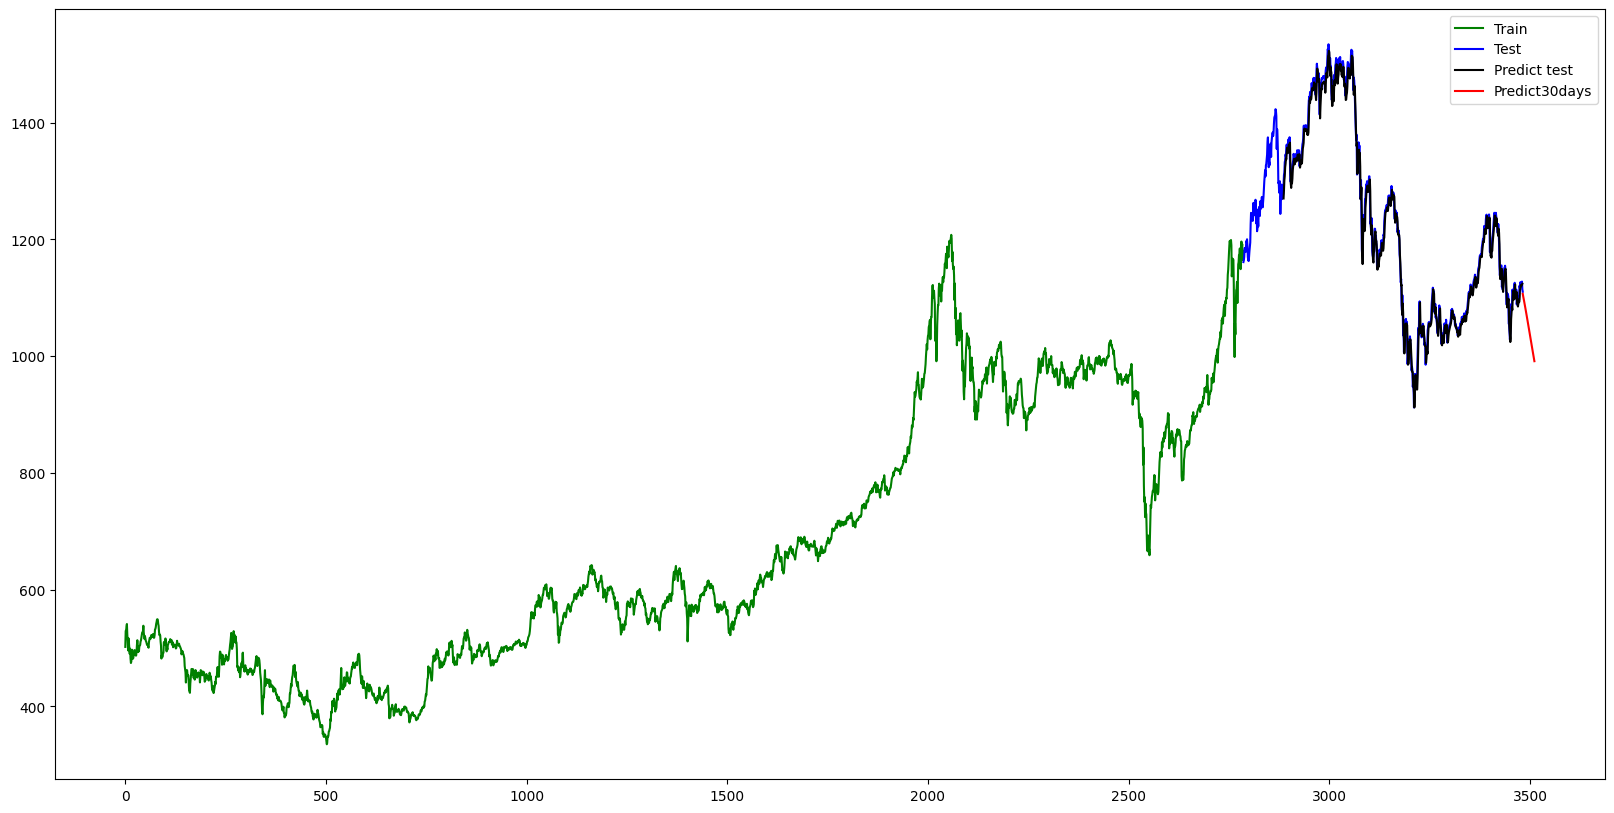

In [15]:
# 14.Vẽ hình
plt.figure(figsize=(20, 10))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data),color='green')
test_data_index = pd.RangeIndex(start=train_size, stop=len(df), step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data),color='blue')
test_data_index = pd.RangeIndex(start=train_size+100, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred, color='black')
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output),color='red')
plt.legend(['Train','Test','Predict test','Predict30days'])
plt.show()